# Analyze Power Usage Data

#### Description of the Dataset
Source: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption#

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months). 

Notes: 

1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


Attribute Information:

1.date: Date in format dd/mm/yyyy 

2.time: time in format hh:mm:ss 

3.global_active_power: household global minute-averaged active power (in kilowatt) 

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 

5.voltage: minute-averaged voltage (in volt) 

6.global_intensity: household global minute-averaged current intensity (in ampere) 

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### Remove this cell on databrics. Only for jupyter

In [1]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

#### Load the data into an RDD

In [2]:
import numpy as np
import matplotlib.pyplot as pyplot
import matplotlib.ticker as ticker

In [3]:
#read txt file, gzipped files will be auto-unzipped
myRDD = sc.textFile("household_power_consumption.txt.gz")

print (myRDD.count())
myRDD.take(5)

2075260


['Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3',
 '16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000',
 '16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000',
 '16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000',
 '16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000']

#### Start Your Analysis Here

<h5> Some helper functions </h5>

In [44]:
from datetime import datetime

def getFloat(x):
  try:    y = float(x)
  except: y = 0
  return y

def getDate(x):
  try: y = datetime.strptime(x,"%d/%m/%Y").date()
  except ValueError: 
    y = datetime.strptime("01/01/1901","%d/%m/%Y").date()  
  return y
    

<h5> Get a CleanRDD </h5>
<ul>
    <li> Get each individual data element 
    <li> Convert it to the right format (date,float, etc)
    <li> Convert global active power to watt-hour
    <li> Add field for "other"
</ul>

In [45]:
import re
p = re.compile('(.*?)(?:;|\\Z)')

# Clean the data, and convert global active energy into watt-hour
cleanRDD = myRDD.map(lambda l: p.findall(l)).map(lambda x: (getDate(x[0]),str(x[1]),getFloat(x[2])*1000/60,getFloat(x[3]),getFloat(x[4]),getFloat(x[5]),getFloat(x[6]), getFloat(x[7]), getFloat(x[8]), getFloat(x[2])*1000/60 - (getFloat(x[6]) + getFloat(x[7]) + getFloat(x[8])) ))
cleanRDD = cleanRDD.filter(lambda x: (x[0].year >= 2006) and (x[0].year <= 2010))

In [46]:
cleanRDD.count()

2075259

<h5> Get "Day of the Week" Data (e.g Mon, Tue) </h5>

In [47]:
# Eliminate time
# Aggregate the full day's data
dailyRDD = cleanRDD.map(lambda x: (x[0],(x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]))).reduceByKey( lambda v1,v2: (v1[0]+v2[0],v1[1]+v2[1],v1[2]+v2[2],v1[3]+v2[3],v1[4]+v2[4],v1[5]+v2[5],v1[6]+v2[6],v1[7]+v2[7])).sortByKey().map(lambda x: [x[0]]+list(x[1]))

dailyRDD.take(1)

[[datetime.date(2006, 12, 16),
  20152.933333333356,
  34.921999999999976,
  93552.53000000006,
  5180.8000000000075,
  0.0,
  546.0,
  4926.0,
  14680.933333333334]]

In [48]:
spark = pyspark.sql.SparkSession(sc)

weekDayRDD = dailyRDD.map( lambda x: (x[0].strftime('%w (%a)'), x[1:])).reduceByKey(lambda v1,v2: (np.add(v1,v2)).tolist()).sortByKey().map(lambda x: [x[0]] + list(x[1]))
weekDayRDD.take(1)
weekDayDF = weekDayRDD.toDF().toDF('WeekDay',
               'Total (W/hr)',
               'global_reactive_power',
               'voltage', 
               'global_intensity',
               'Kitchen (W/hr)',
               'Laundry room (W/hr)',
               'Water-heater & Air-conditioner (W/hr)',
               'Other (W/hr)')

<h5> Get "Hour of the Day" (e.g 1AM, 2AM) </h5>

In [49]:
hourOfDayDF = cleanRDD.map(lambda x: (x[1].split(':')[0],x[2:])).reduceByKey( lambda v1,v2: (np.add(v1,v2)).tolist()).sortByKey().map(lambda x: [x[0]]+list(x[1]))

hourOfDayDF.take(1)

[['00',
  939594.7999999663,
  9829.20799999984,
  20723173.08,
  239964.80000000316,
  31151.0,
  47481.0,
  253622.0,
  607340.7999999861]]

In [50]:
hourOfDayDF = hourOfDayDF.toDF().toDF('HourOfDay',
               'Total (W/hr)',
               'global_reactive_power',
               'voltage', 
               'global_intensity',
               'Kitchen (W/hr)',
               'Laundry room (W/hr)',
               'Water-heater & Air-conditioner (W/hr)',
               'Other (W/hr)')

<h3> Lets Analyse </h3>

<h5> Plotting Helper functions </h5>

In [51]:
def simpleWeekDayGraph(ydata, yaxis, title):
   days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
   return simpleGraph(ydata, yaxis, range(0,7), days, "Weekdays", title)
  
  
def monthGraph(ydata, yaxis, title):
   month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
   return simpleGraph(ydata, yaxis, range(0,12), month, "Month", title)

def hourGraph(ydata, yaxis, title):
   hours = [ str(i) for i in range(0,24) ] 
   return simpleGraph(ydata, yaxis, range(0,24), hours, "Hour of Day", title)
  
def simpleGraph(ydata, yaxis, xdata, xlabel, xaxis, title):
   x = np.array(xdata)
   y = np.array(ydata)
   fig = pyplot.figure(figsize = (20,5))
   ax = fig.add_subplot(111)
   ax.yaxis.grid(which="major", color=(0.1,0.1,0.1), linestyle='-', linewidth=0.2)

  
   pyplot.xticks(x,xlabel)
   pyplot.xlabel(xaxis)
   pyplot.ylabel(yaxis)
   pyplot.title(title)
      
   ax.plot(x, y, label="Total (W/hr)")
   pyplot.legend()


   ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
   return fig    

<h4> By Day of Week </h4>

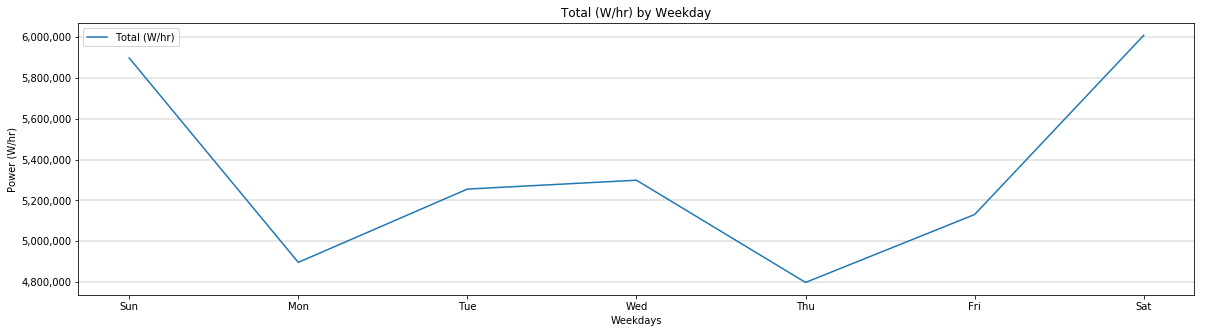

In [52]:
WattHourCol = ["Total (W/hr)", "Kitchen (W/hr)", "Laundry room (W/hr)", "Water-heater & Air-conditioner (W/hr)", "Other (W/hr)"]

c = WattHourCol[0]
simpleWeekDayGraph(weekDayDF.select(c).collect(),"Power (W/hr)", c + " by Weekday")

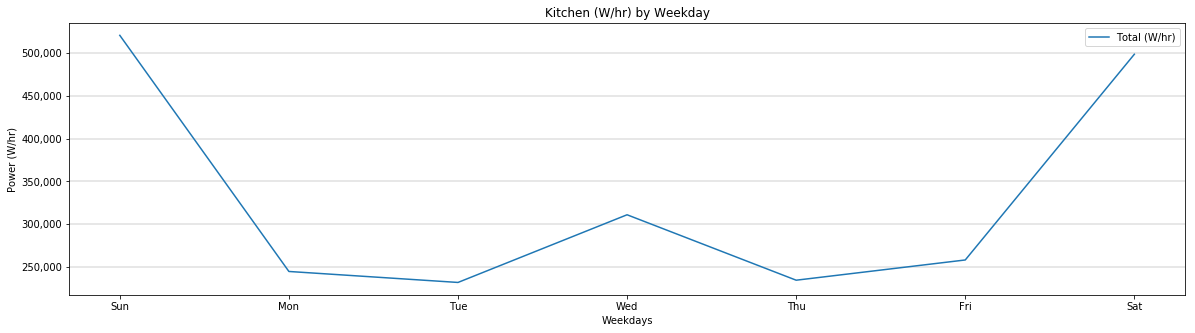

In [53]:
c = WattHourCol[1]
simpleWeekDayGraph(weekDayDF.select(c).collect(),"Power (W/hr)", c + " by Weekday")

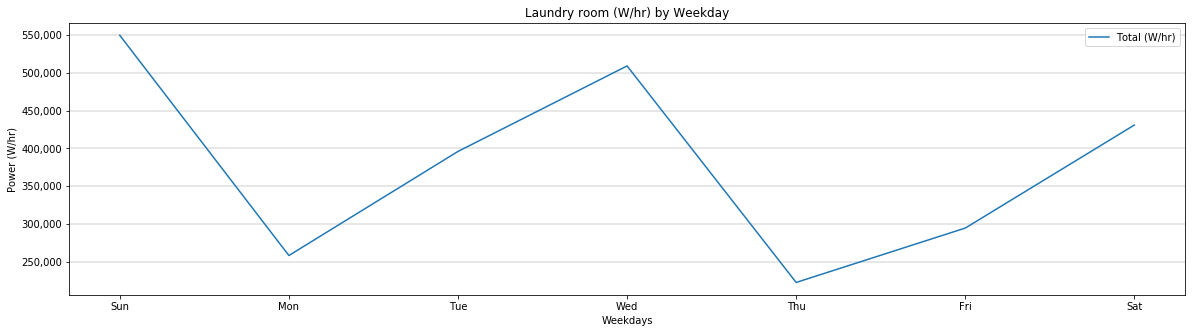

In [54]:
c = WattHourCol[2]
simpleWeekDayGraph(weekDayDF.select(c).collect(),"Power (W/hr)", c + " by Weekday")

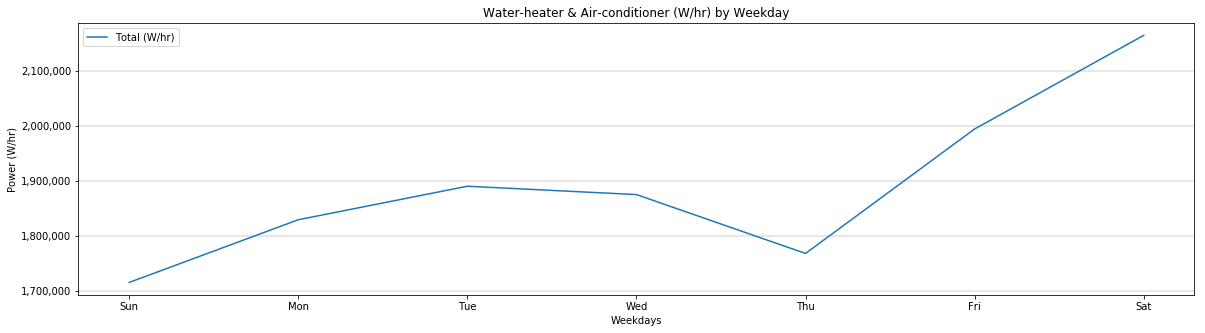

In [55]:
c = WattHourCol[3]
simpleWeekDayGraph(weekDayDF.select(c).collect(),"Power (W/hr)", c + " by Weekday")

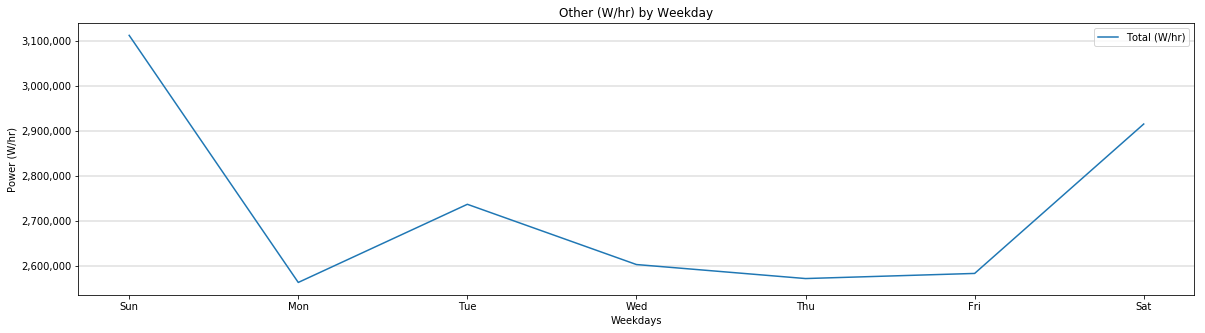

In [56]:
c = WattHourCol[4]
simpleWeekDayGraph(weekDayDF.select(c).collect(),"Power (W/hr)", c + " by Weekday")

<h4> By Month of Year </h4>

In [57]:
monthlyRDD = dailyRDD.map( lambda x: (x[0].strftime('%m (%B)'), x[1:])).reduceByKey(lambda v1,v2: (np.add(v1,v2)).tolist()).sortByKey().map(lambda x: [x[0]] + list(x[1]))

In [58]:
# Rename the columns
monthlyDF = monthlyRDD.toDF().toDF('Month',
               'Total (W/hr)',
               'global_reactive_power',
               'voltage', 
               'global_intensity',
               'Kitchen (W/hr)',
               'Laundry room (W/hr)',
               'Water-heater & Air-conditioner (W/hr)',
               'Other (W/hr)')

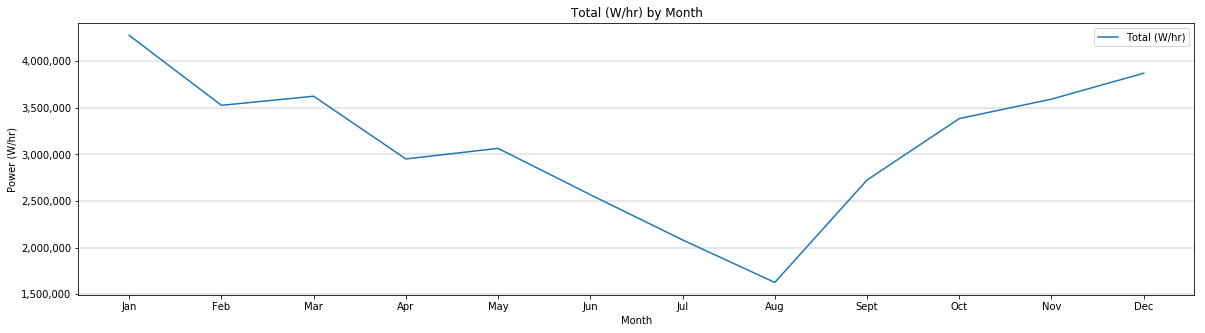

In [59]:
c = WattHourCol[0]
monthGraph(monthlyDF.select(c).collect(),"Power (W/hr)", c + " by Month")

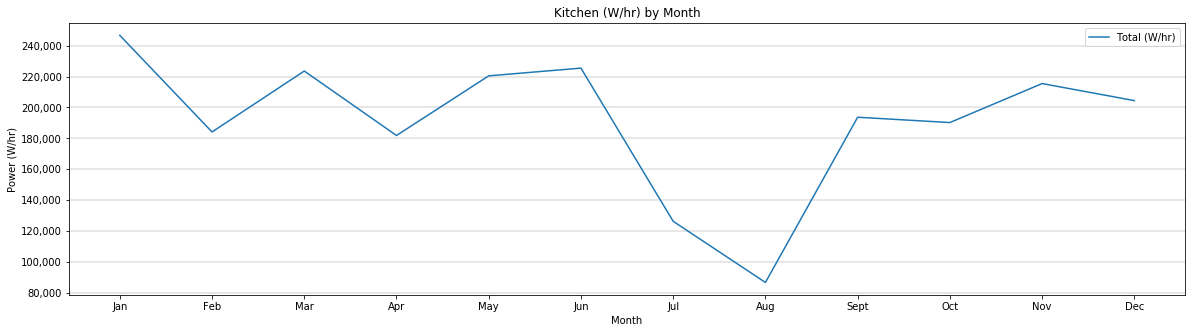

In [60]:
c = WattHourCol[1]
monthGraph(monthlyDF.select(c).collect(),"Power (W/hr)", c + " by Month")

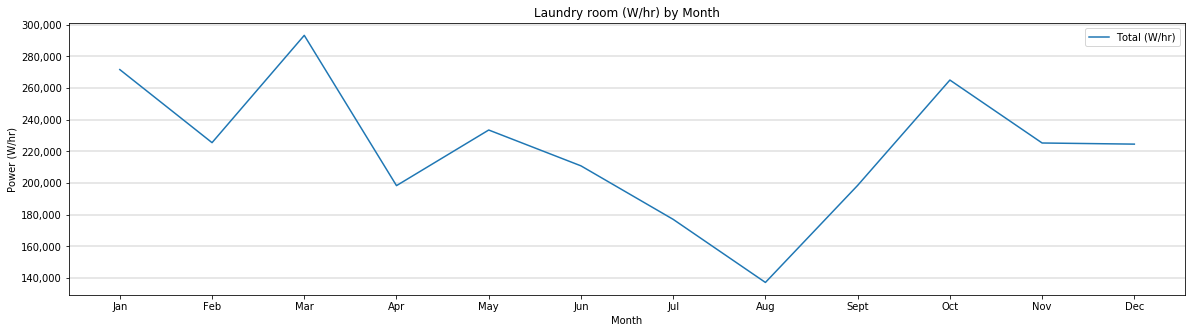

In [61]:
c = WattHourCol[2]
monthGraph(monthlyDF.select(c).collect(),"Power (W/hr)", c + " by Month")

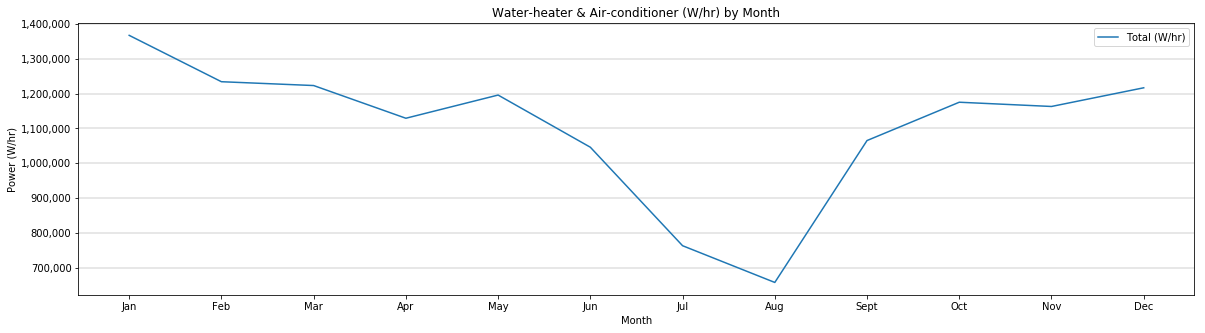

In [62]:
c = WattHourCol[3]
monthGraph(monthlyDF.select(c).collect(),"Power (W/hr)", c + " by Month")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


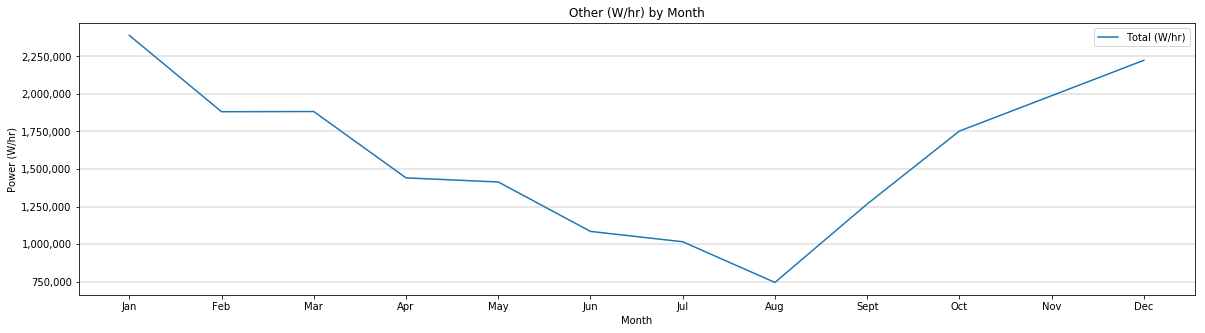

In [63]:
c = WattHourCol[4]
monthGraph(monthlyDF.select(c).collect(),"Power (W/hr)", c + " by Month")

<h4> By Hour of Day </h4>

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


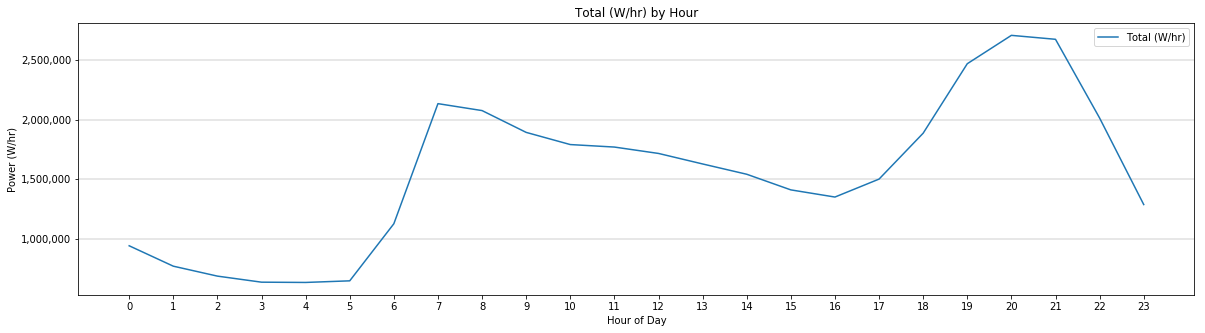

In [64]:
c = WattHourCol[0]
hourGraph(hourOfDayDF.select(c).collect(),"Power (W/hr)", c + " by Hour")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


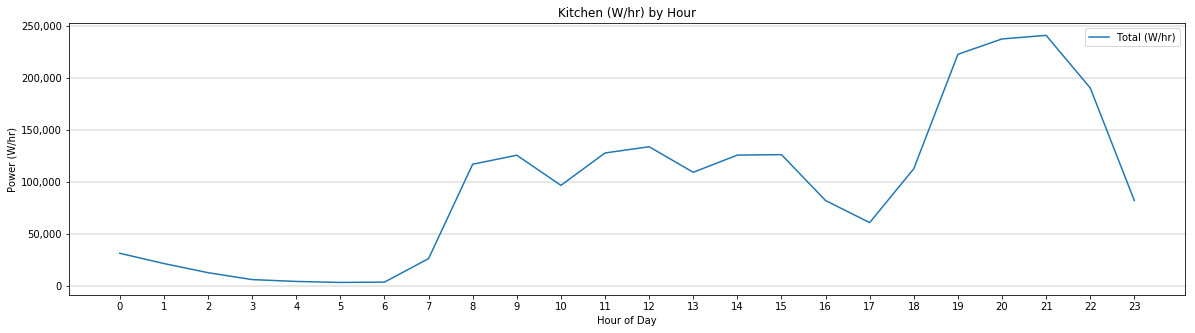

In [65]:
c = WattHourCol[1]
hourGraph(hourOfDayDF.select(c).collect(),"Power (W/hr)", c + " by Hour")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


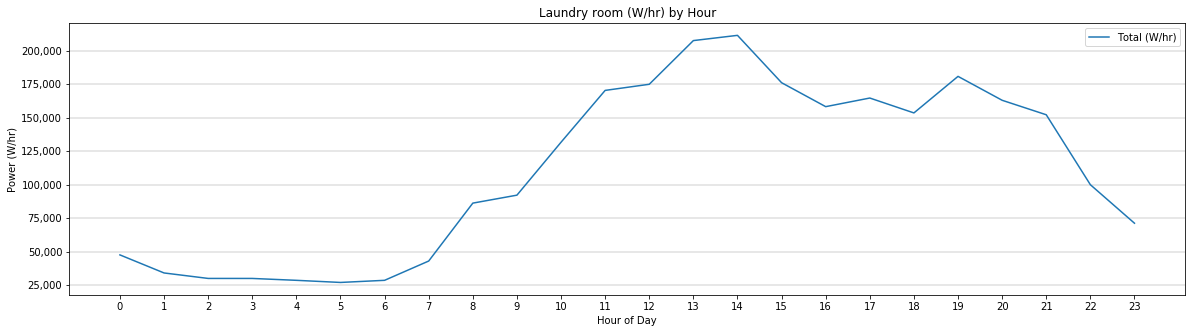

In [66]:
c = WattHourCol[2]
hourGraph(hourOfDayDF.select(c).collect(),"Power (W/hr)", c + " by Hour")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


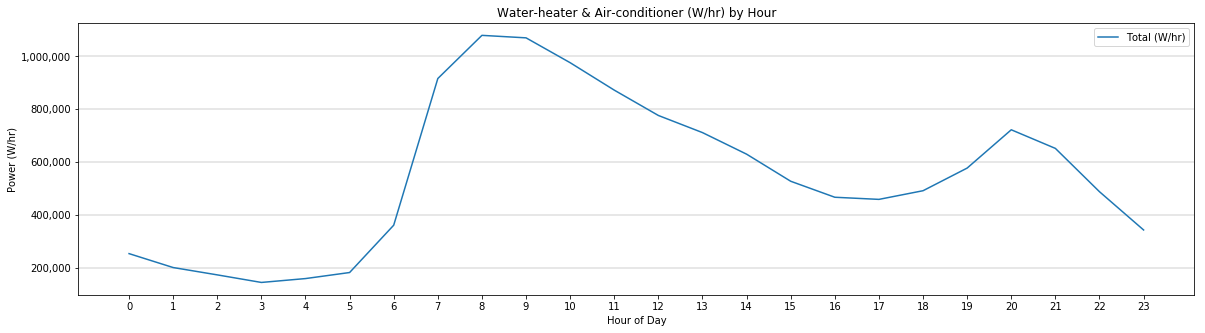

In [67]:
c = WattHourCol[3]
hourGraph(hourOfDayDF.select(c).collect(),"Power (W/hr)", c + " by Hour")

In [68]:
c = WattHourCol[4]
hourGraph(hourOfDayDF.select(c),"Power (W/hr)", c + " by Hour")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


TypeError: object of type 'DataFrame' has no len()